# Summary of task and results

### Problem statement
The Hands-on task for Senior Data Scientist

To complete this assignment you will need the publicly available dataset of Online Retail provided by the UCI, which you can find in http://archive.ics.uci.edu/ml/datasets/Online+Retail+II.
Please complete the tasks below and provide an answer, including code and a walkthrough of the reasoning/conclusions of each step, preferably in runnable notebook format (Python or Scala are recommended, but feel free to use whatever language and technology you're comfortable with). The dataset contains transactions (including cancellations) carried out by an online retailer (mainly focused on gift items) between 01/12/2009 and 09/12/2011.

Your job is to 1. Perform a detailed EDA of the dataset, providing the most relevant business insights. 2. Split the customers into groups according to their purchase patterns and product purchases, and characterize/quantify the obtained customer personas. 3. Have any users churned during the second half of 2011? Are there any users at high risk of churning by the end of 2011?

### Notable results

We have separated the customers into 5 groups based on their spending patterns using RFM (recency, frequency and monetary) variables. 
We have the following clusters:

* 0: high frequency, high monetary, recent purchase <- the moneymakers!
* 1: medium frequency, medium monetary, high recency
* 2: low frequency, low monetary, recent purchase
* 3: medium frequency, medium monetary, recent purchase<-second best moneywise
* 4: low frequency, low monetary, high recency, 


We have also identified 171 customers who have churned in the second half of 2011 and modeled the changes in recency, monetary and frequency to identify 95 customers who are in danger of churning at the end of 2011.  

## Load necessary modules and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud as wc
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import datasets
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.ExcelFile("online_retail_II.xlsx")

dtypes = {'Invoice': str, 'StockCode': str, 'Description': str, 'Quantity': int, 
          'InvoiceDate': str, 'Price': float, 'CustID':float, 'Country': str}
df_2009 = pd.read_excel(data, "Year 2009-2010", 
                        dtype=dtypes,  parse_dates=["InvoiceDate"])  
df_2010 = pd.read_excel(data, "Year 2010-2011", 
                        dtype=dtypes, parse_dates=["InvoiceDate"])

In [3]:
df_2009.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01T07:45:00.000000000,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01T07:45:00.000000000,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01T07:45:00.000000000,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01T07:45:00.000000000,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01T07:45:00.000000000,1.25,13085.0,United Kingdom


In [4]:
df_2009.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [5]:
#rename Customer ID column to make it easier to work with
df_2009['custID']=df_2009['Customer ID']
df_2009 = df_2009.drop(columns="Customer ID")
df_2009['totalPrice'] = [x*y for (x,y) in zip(df_2009.Price, df_2009.Quantity)]

df_2010['custID']=df_2010['Customer ID']
df_2010 = df_2010.drop(columns="Customer ID")
df_2010['totalPrice'] = [x*y for (x,y) in zip(df_2010.Price, df_2010.Quantity)]

### Let's look at the data

In [6]:
print(len(set(df_2009.Country)))
print(set(df_2009.Country))

40
{'Italy', 'Unspecified', 'Belgium', 'Thailand', 'Switzerland', 'United Arab Emirates', 'Iceland', 'United Kingdom', 'Netherlands', 'Hong Kong', 'RSA', 'Poland', 'Israel', 'West Indies', 'Lebanon', 'Singapore', 'Norway', 'Bermuda', 'Nigeria', 'Greece', 'France', 'Malta', 'Sweden', 'Lithuania', 'Germany', 'Denmark', 'Spain', 'Portugal', 'Canada', 'Brazil', 'Japan', 'Channel Islands', 'Korea', 'Australia', 'Cyprus', 'EIRE', 'Finland', 'Bahrain', 'USA', 'Austria'}


In [7]:
print("Number of invoices", len(df_2009.Invoice.unique()))
print("Number of different customers ", len(df_2009.custID.unique()))

Number of invoices 28816
Number of different customers  4384


In [110]:
def canceled(invoice):
    if invoice[0]=='C':
        return True
    else:
        return False

print("Number of cancelled invoices: ", sum(map(canceled, df_2009.Invoice.unique())))

print("Percentage of cancelled invoices: {:0.2f}%".format(100.*sum(map(canceled, df_2009.Invoice.unique()))/len(df_2009.Invoice.unique())))

Number of cancelled invoices:  4372
Percentage of cancelled invoices: 18.54%


#### That's a very high percentage of canceled orders.  

In [9]:
df_2009.describe()

,Quantity,Price,custID,totalPrice
count,525461.000000,525461.000000,417534.000000,525461.000000
mean,10.337667,4.688834,15360.645478,18.154506
std,107.424110,146.126914,1680.811316,160.333083
min,-9600.000000,-53594.360000,12346.000000,-53594.360000
25%,1.000000,1.250000,13983.000000,3.750000
50%,3.000000,2.100000,15311.000000,9.950000
75%,10.000000,4.210000,16799.000000,17.700000
max,19152.000000,25111.090000,18287.000000,25111.090000


### Negative numbers in quantity and price indicate missing/null values.  Let's look closer

In [10]:
negs = list(np.where(df_2009.Quantity < 0))[0]

df_2009[['Description', 'Quantity', 'Price']].loc[negs]

,Description,Quantity,Price
178,PAPER BUNTING WHITE LACE,-12,2.95
179,CREAM FELT EASTER EGG BASKET,-6,1.65
180,POTTING SHED SOW 'N' GROW SET,-4,4.25
181,POTTING SHED TWINE,-6,2.10
182,PAPER CHAIN KIT RETRO SPOT,-12,2.95
...,...,...,...
525231,NaN,-18,0.00
525232,NaN,-32,0.00
525234,Dotcom sales,-100,0.00
525235,Dotcom sales,-100,0.00


### Okay, so cancelled orders have a negative quantity... but not a negative price.  Where are the negative prices coming from?

In [11]:
negs = np.where(df_2009.Price < 0)
negvals = [df_2009.Price[x] for x in negs]
print(negs)

(array([179403, 276274, 403472]),)


In [12]:
for index in negs:
    print(df_2009.loc[index])

        Invoice StockCode      Description  Quantity  \
179403  A506401         B  Adjust bad debt         1   
276274  A516228         B  Adjust bad debt         1   
403472  A528059         B  Adjust bad debt         1   

                          InvoiceDate     Price         Country  custID  \
179403  2010-04-29T13:36:00.000000000 -53594.36  United Kingdom     NaN   
276274  2010-07-19T11:24:00.000000000 -44031.79  United Kingdom     NaN   
403472  2010-10-20T12:04:00.000000000 -38925.87  United Kingdom     NaN   

        totalPrice  
179403   -53594.36  
276274   -44031.79  
403472   -38925.87  


#### So the negative prices come from a debt adjustment and can be ignored for the purposes of this exercise. They also have no customer ID.  I probably want to remove all records with no customer IDs, but before I do that, let me check to see how common they are and what kind of records they are.  

In [13]:
noID = np.where(df_2009.custID.isnull())
print(len(noID[0]))

107927


#### That's a lot of records with no ID.  Let's look further...

In [14]:
print(df_2009.loc[noID[0][0:10]])
print(set(df_2009.Country[noID[0]]))

     Invoice StockCode                   Description  Quantity  \
263   489464     21733                  85123a mixed       -96   
283   489463     71477                         short      -240   
284   489467    85123A                   21733 mixed      -192   
470   489521     21646                           NaN       -50   
577   489525    85226C     BLUE PULL BACK RACING CAR         1   
578   489525     85227   SET/6 3D KIT CARDS FOR KIDS         1   
1055  489548     22271          FELTCRAFT DOLL ROSIE         1   
1056  489548     22254          FELT TOADSTOOL LARGE        12   
1057  489548     22273          FELTCRAFT DOLL MOLLY         3   
1058  489548     22195  LARGE HEART MEASURING SPOONS         1   

                        InvoiceDate  Price         Country  custID  totalPrice  
263   2009-12-01T10:52:00.000000000   0.00  United Kingdom     NaN       -0.00  
283   2009-12-01T10:52:00.000000000   0.00  United Kingdom     NaN       -0.00  
284   2009-12-01T10:53:00.0000

#### Hard to tell what these are -- some look like restock, maybe some are purchases under guest accounts?  They also come from a variety of countries.  In any case, we will need to exclude these from our analysis. 

## Removing all rows with no customer ID

In [15]:
print("2009: dropping rows with no customer ID")
print("length before: ", len(df_2009.Invoice))
df_2009=df_2009.drop(noID[0], axis=0)
print("length after: ", len(df_2009.Invoice))
#reindex
df_2009.reset_index(inplace=True)

noID = np.where(df_2010.custID.isnull())
print("2010: dropping rows with no customer ID")
print("length before: ", len(df_2010.Invoice))
df_2010=df_2010.drop(noID[0], axis=0)
print("length after: ", len(df_2010.Invoice))
#reindex
df_2010.reset_index(inplace=True)

2009: dropping rows with no customer ID
length before:  525461
length after:  417534
2010: dropping rows with no customer ID
length before:  541910
length after:  406830


## Now let's concatanate the two years of data.

In [16]:
df_retail = pd.concat([df_2009, df_2010], axis=0)
df_retail.reset_index(inplace=True)
df_retail.head()

,level_0,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,custID,totalPrice
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01T07:45:00.000000000,6.95,United Kingdom,13085.0,83.4
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01T07:45:00.000000000,6.75,United Kingdom,13085.0,81.0
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01T07:45:00.000000000,6.75,United Kingdom,13085.0,81.0
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01T07:45:00.000000000,2.10,United Kingdom,13085.0,100.8
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01T07:45:00.000000000,1.25,United Kingdom,13085.0,30.0


In [17]:
df_retail.describe()

,level_0,index,Quantity,Price,custID,totalPrice
count,824364.000000,824364.000000,824364.000000,824364.000000,824364.000000,824364.000000
mean,206125.246670,271491.670034,12.414574,3.676800,15324.638504,20.195317
std,119046.929247,150554.198006,188.976099,70.241388,1697.464450,308.685001
min,0.000000,0.000000,-80995.000000,0.000000,12346.000000,-168469.600000
25%,103045.000000,143189.750000,2.000000,1.250000,13975.000000,4.250000
50%,206090.500000,275354.500000,5.000000,1.950000,15255.000000,11.250000
75%,309136.000000,400531.250000,12.000000,3.750000,16797.000000,19.500000
max,417533.000000,541909.000000,80995.000000,38970.000000,18287.000000,168469.600000


Great -- now we have no prices below zero and same count of customer ID records as the quantity/price

## Now let's look at canceled orders

In [18]:
#Now looking at canceled orders
negs = list(np.where(df_retail.Quantity < 0))[0]
comp = list(np.where(df_retail.Quantity > 0))[0]
df_retail[['Description', 'Quantity']].loc[negs]

,Description,Quantity
178,PAPER BUNTING WHITE LACE,-12
179,CREAM FELT EASTER EGG BASKET,-6
180,POTTING SHED SOW 'N' GROW SET,-4
181,POTTING SHED TWINE,-6
182,PAPER CHAIN KIT RETRO SPOT,-12
...,...,...
823911,ZINC T-LIGHT HOLDER STARS SMALL,-11
823995,Manual,-1
824169,VICTORIAN SEWING BOX LARGE,-5
824170,HANGING HEART JAR T-LIGHT HOLDER,-1


In [19]:
cancInd = list(map(canceled, df_retail.Invoice))

In [109]:
print("Percentage of canceled orders {:0.2f}%".format(100.0*sum(cancInd)/len(cancInd)))

Percentage of canceled orders2.27%


#### 2% cancelled is much more reasonable than the 16% we found above for 2009.  

In [21]:
print(np.where(cancInd))

(array([   178,    179,    180, ..., 824169, 824170, 824171]),)


In [22]:
df_retail.loc[178]

level_0                                  178
index                                    178
Invoice                              C489449
StockCode                              22087
Description         PAPER BUNTING WHITE LACE
Quantity                                 -12
InvoiceDate    2009-12-01T10:33:00.000000000
Price                                   2.95
Country                            Australia
custID                                 16321
totalPrice                             -35.4
Name: 178, dtype: object

## How are cancelled orders handled in the data?

#### Is there an earlier, matching record with no 'C' that shows the original order that was then cancelled?

In [23]:
completed = df_retail.Invoice[~np.array(cancInd)].unique()
cancelled = df_retail.Invoice[cancInd].unique()

for canc in cancelled:
    if canc[1:] in cancelled:
        print("match")

#### Okay, no matches -- so canceled orders are not duplicates of already created orders.  Is there a difference between canceled orders and completed orders?  Let's check the wordclouds.

In [24]:
can_words = ' '.join(df_retail.Description[cancInd])
comp_words = ' '.join(df_retail.Description[~np.array(cancInd)])

### Word cloud for cancelled orders

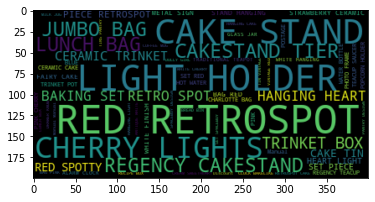

In [25]:
wc_cans = wc.WordCloud().generate(can_words)
plt.imshow(wc_cans, interpolation='bilinear')

### Word cloud for completed orders

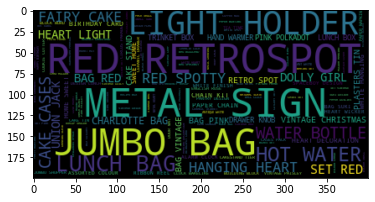

In [26]:
wc_comp = wc.WordCloud().generate(comp_words)
plt.imshow(wc_comp, interpolation='bilinear')

#### Some differences -- "Jumbo bag" and "Red Retrospot" are words that show up often in  completed orders while "Cake Stand" and Cherry lights" are often cancelled.  "Light Holder" and "Red Retrospot" show up in both categories.  Could be worth some effort to look at more closely at the cancelled items to see if their descriptions are confusing or if the names are very close to another item name.  
#### For now, let's pull canceled orders out into a separate dataframe. df_retailC = canceled orders; df_retailG = "good" (completed) orders

In [27]:
df_retailC = df_retail.loc[cancInd].copy(deep=True)
df_retailG = df_retail.loc[~np.array(cancInd)].copy(deep=True)


In [28]:
Items = df_retailG.groupby('Description')
print("Most popular items:")
Items['Quantity'].sum().sort_values()[-10:]

Most popular items:


Description
PACK OF 72 RETROSPOT CAKE CASES        46107
60 TEATIME FAIRY CAKE CASES            53495
PACK OF 60 PINK PAISLEY CAKE CASES     55270
BROCADE RING PURSE                     71129
JUMBO BAG RED RETROSPOT                75759
MEDIUM CERAMIC TOP STORAGE JAR         77916
ASSORTED COLOUR BIRD ORNAMENT          79913
PAPER CRAFT , LITTLE BIRDIE            80995
WHITE HANGING HEART T-LIGHT HOLDER     93640
WORLD WAR 2 GLIDERS ASSTD DESIGNS     109169
Name: Quantity, dtype: int64

In [29]:
Items = df_retailC.groupby('Description')
print("Items most canceled:")
Items['Quantity'].sum().sort_values()[:10]

Items most canceled:


Description
PAPER CRAFT , LITTLE BIRDIE           -80995
MEDIUM CERAMIC TOP STORAGE JAR        -74494
ROTATING SILVER ANGELS T-LIGHT HLDR   -18730
SET/6 FRUIT SALAD PAPER CUPS           -7140
SET/6 FRUIT SALAD  PAPER PLATES        -7008
Manual                                 -5311
POP ART PEN CASE & PENS                -5184
BLACK SILVER FLOWER T-LIGHT HOLDER     -5040
MULTICOLOUR SPRING FLOWER MUG          -4996
TEATIME PEN CASE & PENS                -4632
Name: Quantity, dtype: int64

#### Again -- might be worth checking on these orders that are often cancelled.  The difference between these lists and the word clouds is that these show the particular items, while the word clouds pick out keywords -- there are several items with "Light holder" in the title, for instance (e.g. GLASS STAR FROSTED T-LIGHT HOLDER, WHITE HANGING HEART T-LIGHT HOLDER, etc).

In [30]:
countries = df_retailC.groupby('Country')
#print("Countries listed by amount of canceled orders")
canceledprice = countries.totalPrice.sum().sort_values()
#print(canceledprice)

In [31]:
countries = df_retailG.groupby('Country')
#print("Countries listed by amount of completed orders")
completedprice = countries.totalPrice.sum().sort_values()
#print(completedprice)

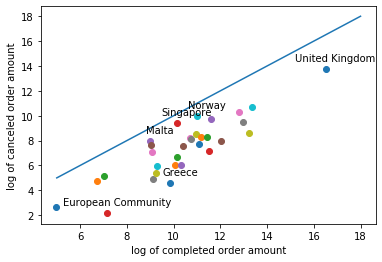

In [32]:
for country in completedprice.index:
    try:
        plt.scatter(np.log(completedprice[country]), np.log(-canceledprice[country]), label=country)
        #Add just a few labels
        if country in ['United Kingdom', 'Norway','Malta', 'Greece','Singapore', 'European Community']:
            plt.annotate(country, (np.log(completedprice[country]), np.log(-canceledprice[country])),
                textcoords="offset points", # how to position the text
                xytext=(10,8), # distance from text to points (x,y)
                ha='center')
    except:
        pass
#        print(country)
        

#plt.legend(loc='best', fontsize=8)
plt.xlabel('log of completed order amount')
plt.ylabel('log of canceled order amount')
plt.plot([5,18], [5,18])

### Cancelled orders correlate with completed orders  -- TL;DR: nothing suspicious
#### The value of cancelled orders basically correlates with completed order with an offset indicating more completed orders than cancelled orders (as one would hope).  Norway, Singapore and Malta have a relatively high portion of canceled orders, while Greece and the European community have a relatively low percentage of canceled orders.  

# Summary of date cleaning and EDA


## Part 2
#### "2. Split the customers into groups according to their purchase patterns and product purchases, and characterize/quantify the obtained customer personas."

#### Make columns for "recency", "monetary" and "frequency" (following https://link.springer.com/article/10.1057/dbm.2012.17)

In [33]:
df_retailG['recency'] = [(datetime(2011, 12, 12) - x).days for x in pd.to_datetime(df_retailG['InvoiceDate'])]
df_retailG['monetary'] = [x*y for (x,y) in zip(df_retailG['Quantity'], df_retailG['Price'])]


In [34]:
gb_custID = df_retailG.groupby('custID')

freq = gb_custID['Invoice'].count()
mon = gb_custID['monetary'].sum()
rec = gb_custID['recency'].min()


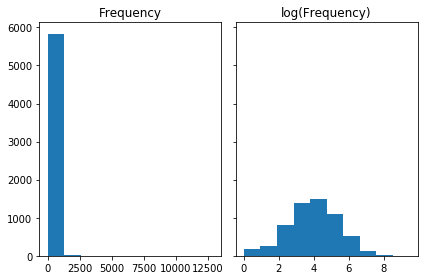

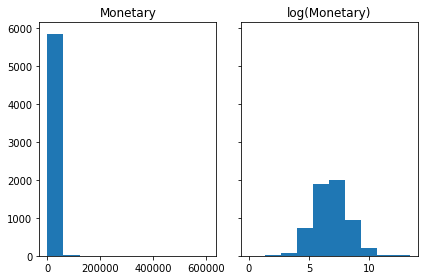

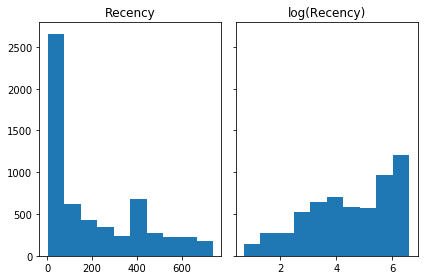

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True)
ax1.hist(freq)
ax1.title.set_text('Frequency')
ax2.hist(np.log(freq))
ax2.title.set_text('log(Frequency)')
plt.show()

logmon = [np.log(x) if x>0 else 0 for x in gb_custID['monetary'].sum()]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True)
ax1.hist(mon)
ax1.title.set_text('Monetary')
ax2.hist(logmon)
ax2.title.set_text('log(Monetary)')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True)
ax1.hist(rec)
ax1.title.set_text('Recency')
ax2.hist(np.log(rec))
ax2.title.set_text('log(Recency)')

plt.show()


## Monetary and Frequency data are strongly exponential
As in https://link.springer.com/article/10.1057/dbm.2012.17, we find large values really affect our distribution.  The article cited deals with this by filtering out large values, but given the distribution of the data it seems more appropriate to take the log of the Frequency and Monetary data. Though Recency also has a dropoff with large values, it is not nearly as extreme and logging the data (see above) doesn't create a gaussian and actually seems to distort the data.

## So we take the log of frequency and monetary, normalize all three RFM variables and create a new dataframe cust_fmr

In [62]:
gb_custID = df_retailG.groupby('custID')

freq = [np.log(x) for x in gb_custID['Invoice'].count()]
mon = [np.log(x) if x>0 else 0 for x in gb_custID['monetary'].sum()]
log_rec = [np.log(x) for x in gb_custID['recency'].min()]

#now normalize
norm_freq = preprocessing.normalize([freq], norm='max')[0]
norm_mon = preprocessing.normalize([mon], norm='max')[0]
norm_rec = preprocessing.normalize([rec], norm='max')[0]


cust_fmr = pd.DataFrame([norm_freq, norm_mon, norm_rec]).T.copy(deep=True)
cust_fmr.columns = ['Frequency', 'Monetary', 'Recency']
cust_fmr.head(10)

,Frequency,Monetary,Recency
0,0.372600,0.845298,0.441892
1,0.584665,0.648417,0.005405
2,0.415442,0.571394,0.104054
3,0.545718,0.630354,0.027027
4,0.299361,0.436385,0.421622
5,0.321688,0.428467,0.509459
6,0.489711,0.597256,0.051351
7,0.335797,0.451092,0.278378
8,0.429032,0.524365,0.316216
9,0.375663,0.514588,0.291892


## Cluster analysis
Here we run the kmeans cluster algorithm with 2-7 clusters to see what works best for our purposes

/Users/alyshareinard/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


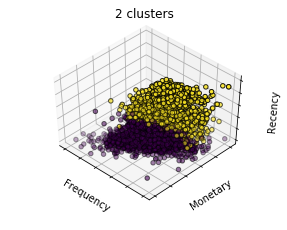

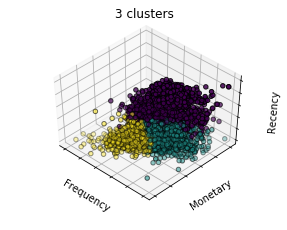

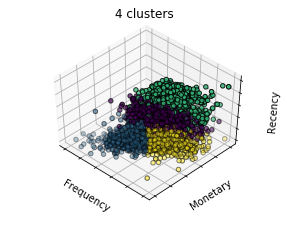

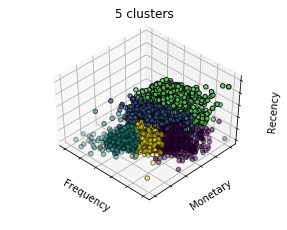

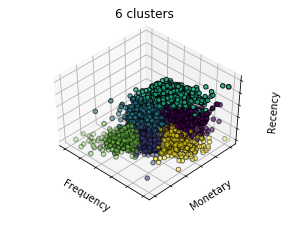

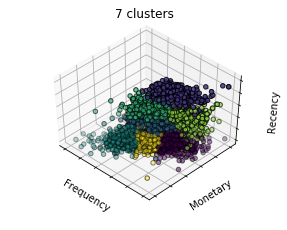

In [37]:
X = cust_fmr

estimators = []
titles = []
for i in range(2,8):
    estimators.append(('kmeans'+str(i)+"clusters", KMeans(n_clusters=i)))
    titles.append(str(i) + ' clusters')


fignum = 1
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X.Frequency, X.Monetary, X.Recency,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Monetary')
    ax.set_zlabel('Recency')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1


fig.show()

##### Number of clusters
Looking at the above figures, it seems that
* 2 clusters: mainly separates based on recency
* 3 clusters: keeps a similar recency split, but then splits again in the monetary/frequency space
* 4 clusters: adds an additional recency slice that cuts across monetary and frequency space
* 5 clusters: adds an additional split in monetary/frequency space.
* 6 clusters +: interpretation becomes more complicated.  

For our purposes of identifying churn, while quantifying purchase patterns and products, we will move forward with 5 clusters. 

In [38]:
kmeans = KMeans(n_clusters=5).fit(cust_fmr)

[[0.60984376 0.64453864 0.05042685]
 [0.38221185 0.48084779 0.50765936]
 [0.25001378 0.41946041 0.14559797]
 [0.44412002 0.52643427 0.08929812]
 [0.26079551 0.40956173 0.81082524]]


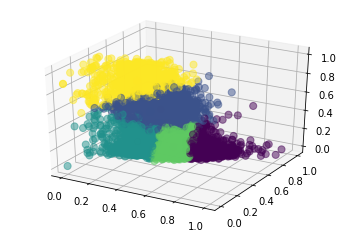

In [39]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(cust_fmr['Frequency'].values, cust_fmr['Monetary'].values, cust_fmr['Recency'].values, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter3D(centroids[:, 0], centroids[:, 1], centroids[:,2], c='red', s=50)


In [40]:
labels[0:10]

array([1, 0, 3, 0, 1, 1, 3, 2, 1, 3], dtype=int32)

#### We add the "label" column to the cust_frm dataframe to identify the cluster each customer is in

In [41]:
cust_fmr['cluster']=labels

#### And we group by clusters

In [42]:
clusters =cust_fmr.groupby("cluster")

In [43]:
clusters.mean()

,Frequency,Monetary,Recency
cluster,,,
0,0.610323,0.644947,0.050277
1,0.382270,0.480886,0.507552
2,0.250136,0.419505,0.145526
3,0.444587,0.526719,0.089231
4,0.260855,0.409590,0.810611


#### We have a 'customers' variable can use it to map these clusters back to the original data.  

In [44]:
all_custids = df_retailG.custID
all_custidsC = df_retailC.custID

customers = list(gb_custID.groups.keys())

all_labels = []
labels = list(labels)
all_labelsC=[]
for custid in all_custids:
    all_labels.append(labels[customers.index(custid)])
    
#Cancelled orders may also be relevant
for custid in all_custidsC:
    if custid in customers:
        all_labelsC.append(labels[customers.index(custid)])
    else:
        all_labelsC.append(-1)

In [45]:
df_retailG['labels']=all_labels
df_retailC['labels']=all_labelsC

In [46]:
gb_labels = df_retailG.groupby('labels')
gb_labelsC = df_retailC.groupby('labels')

#### Do a quick reality check to make sure the labels have been mapped correctly

In [47]:
gb_labels['recency'].min()

labels
0      2
1    220
2      3
3      2
4    376
Name: recency, dtype: int64

#### clusters 2 and 4 have the highest recency, clusters 0, 1 and 3 all similar and low.  

In [48]:
gb_labels['monetary'].sum()

labels
0    1.293850e+07
1    1.463592e+06
2    3.601838e+05
3    2.603839e+06
4    3.773114e+05
Name: monetary, dtype: float64

#### cluster 0 has the highest monetary, cluster 1 and 2 are the lowest -- same as seen above

#### Taking a quick look at cancelled orders:

In [49]:
gb_labels.index.count()

labels
0    565670
1     79168
2     11252
3    133912
4     15618
Name: index, dtype: int64

In [50]:
gb_labelsC.index.count()

labels
-1      129
 0    12710
 1     1869
 2      383
 3     3162
 4      491
Name: index, dtype: int64

#### The rate of cancellation is similar in each of the groups

In [108]:
#Calculating cancelation rates
rates = [100 * x/y for (x,y) in zip(gb_labelsC.index.count()[1:], gb_labels.index.count())]
for rate in rates:
    print("{:0.2f}%".format(rate))


2.25%
2.36%
3.40%
2.36%
3.14%


## Clusters
We have the following clusters: 
* 0: high frequency, high monetary, recent purchase, many cancelled purchases <- the moneymakers!
* 1: medium frequency, medium monetary, high recency, medium cancelled purchases
* 2: low frequency, low monetary, recent purchase, few cancelled
* 3: medium frequency, medium monetary, recent purchase, med-high cancellations <-second best moneywise
* 4: low frequency, low monetary, high recency, low cancelations 

So, oddly, canceled purchases are correlated with the most valued customers -- It's just a volume issue: more volume, more cancellations.  

## Now let's make some plots

In [52]:
#This line takes awhile to run
group_descriptions = gb_labels['Description'].apply(lambda x: x.sum())

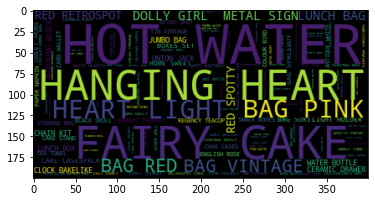

In [53]:
wc_cans = wc.WordCloud().generate(group_descriptions[0])
plt.imshow(wc_cans, interpolation='bilinear')

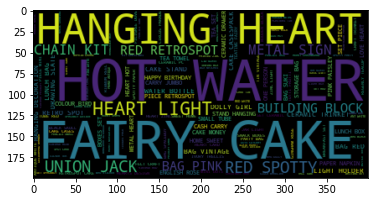

In [54]:
wc_cans = wc.WordCloud().generate(group_descriptions[1])
plt.imshow(wc_cans, interpolation='bilinear')

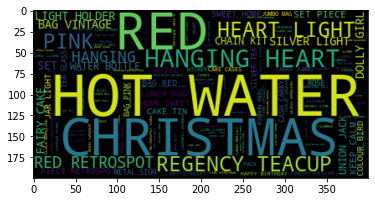

In [55]:
wc_cans = wc.WordCloud().generate(group_descriptions[2])
plt.imshow(wc_cans, interpolation='bilinear')

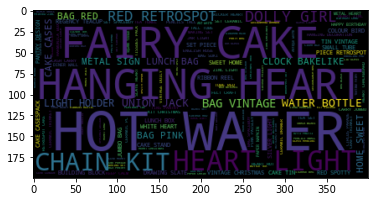

In [56]:
wc_cans = wc.WordCloud().generate(group_descriptions[3])
plt.imshow(wc_cans, interpolation='bilinear')

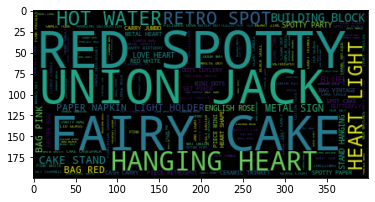

In [57]:
wc_cans = wc.WordCloud().generate(group_descriptions[4])
plt.imshow(wc_cans, interpolation='bilinear')

In [58]:
#Next look at top ten list for each group

In [59]:
len(gb_labels)

5

In [60]:
Items = df_retailG.groupby(['labels', 'Description'])['Quantity'].sum()
for i in range(5):
    print("Top items for group ", i, ": ")
    print(Items[i].sort_values()[-10:])
    print("\n")

Top items for group  0 : 
Description
SMALL POPCORN HOLDER                  35983
PACK OF 72 RETRO SPOT CAKE CASES      37101
PACK OF 72 RETROSPOT CAKE CASES       38383
60 TEATIME FAIRY CAKE CASES           41368
PACK OF 60 PINK PAISLEY CAKE CASES    46625
BROCADE RING PURSE                    54792
ASSORTED COLOUR BIRD ORNAMENT         62643
JUMBO BAG RED RETROSPOT               64559
WORLD WAR 2 GLIDERS ASSTD DESIGNS     67734
WHITE HANGING HEART T-LIGHT HOLDER    69948
Name: Quantity, dtype: int64


Top items for group  1 : 
Description
ASSTD DESIGN BUBBLE GUM RING           6060
BAG 250g SWIRLY MARBLES                6828
FAIRY CAKE FLANNEL ASSORTED COLOUR     7014
SET/6 FRUIT SALAD  PAPER PLATES        7034
SET/6 FRUIT SALAD PAPER CUPS           7160
MINI HIGHLIGHTER PENS                  9840
RED  HARMONICA IN BOX                 10652
WHITE HANGING HEART T-LIGHT HOLDER    10977
WORLD WAR 2 GLIDERS ASSTD DESIGNS     28338
MEDIUM CERAMIC TOP STORAGE JAR        74215
Name: Quantit

## Conclusions from cluster analysis

So we've identified several items to make sure we keep in stock.  From the top ten items for group 0 and 3 (the "money makers") we get a good list of items, including the 'white hanging heart t-light holder' and the 'paper craft, little birdie'.  From the word clouds for these two groups we see more general descriptions. For example "Hot water" is prominent -- there are several "Hot water bottle" items and these seem to sell well. Also "Hanging heart", "Heart light" and "Fairy Cake". A further analysis could involve an investigation of these popular terms to see which items containing the terms sell well, and which are often bought together. This information could inform sales tactics.  

## Part 3: 
### Have any users churned during the second half of 2011? Are there any users at high risk of churning by the end of 2011?

#### Let's make a time series of RFM as described in Chen, D., Guo, K., and Li, Bo (2019), Predicting Customer Profitability Dynamically over Time: An Experimental Comparative Study, 24th Iberoamerican Congress on Pattern Recognition (CIARP 2019), Havana, Cuba, 28-31 Oct, 2019 and Chen, D., Guo, K. and Ubakanma, G. (2015), Predicting customer profitability over time based on RFM time series, International Journal of Business Forecasting and Marketing Intelligence, Vol. 2, No. 1, pp.1-18.

Steps are: 
1. step through time periods
2. determine recency, frequency and monetary for each customer according to:
    Purchased in time period t?             RFM values
          Yes                  R(t)=R0; F(t)=F(t-1)+# purchases;  M(t)=M(t-1) + total spending
          No                   R(t)=R(t-1)+1; F(t)=F(t-1), M(t)=M(t-1)
3. run clustering algorithm on all customers for the given time step
4. Assign a score for each cluster (high = 0, med = 1, low = 2) and provide that score to each customer for the timestep -> provides a profitability time series for each customer
5. Train a model on this profitability data

But we want to estimate churn -- so we'll do steps 1 and 2 and then work on predictions from the RFM at each timestep.  

The next cell is very slow -- needs to be made more efficient.  

In [64]:
#okay, I'm going with loops for now -- should make it more efficient later. 
#there's an argument to be made for going with monthly results, 
#but I want to standardize the time span, so I'm going with 30 day increments -- 
#print("num increments", (max(df_retailG['recency']) - min(df_retailG['recency']))/30.)
# so we have 25 30-day increments

RFM_list = []
for customer in customers: 
    RFM_list.append([customer, []])
RFM = pd.DataFrame(RFM_list, columns = ["custID", "Mt"])
RFM.set_index("custID", inplace=True)
num_months=0
for i in range(750, 0, -30):
    print(i)
    num_months+=1
    #first grab the subset of the data in this range
    df_monthly = df_retailG.where((df_retailG.recency <= i) & (df_retailG.recency > i-30))
    df_monthly.dropna(inplace=True)
    
    monthly = df_monthly.groupby("custID", as_index=False).sum()
    #Then step through customers and look for orders
    for customer in customers:
        a = monthly.where(monthly.custID == customer)
        a.dropna(inplace=True)
        if a.empty:
            RFM.loc[customer]['Mt'].append(0.0)

        else:
            RFM.loc[customer]['Mt'].append(float(a.monetary))

In [65]:
PosMonths = []

for series in RFM.Mt:
    PosMonths.append(num_months - series.count(0.0))


(array([2849., 1181.,  848.,  342.,  265.,  114.,  122.,   58.,   51.,
          51.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <a list of 10 Patch objects>)

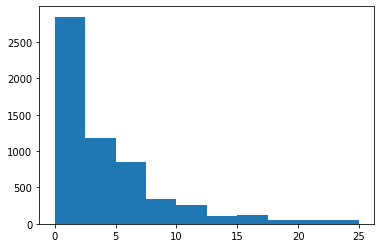

In [66]:
plt.hist(PosMonths) 

#### So most customers don't order monthly.  Let's go back and do quarterly.  

In [67]:
#Now we do 90 day increments "quarters" -- 8 of them -- we skip the first few data points 
# in order to have a consistent size.  Orders before T-720 days are ignored.

# set up a dataframe to keep track of R(t-1)
RFM_list = []
short_customers = [12346.0, 12347.0, 12348.0, 12349.0, 12350.0]
for customer in customers: 
    RFM_list.append([customer, []])
RFM = pd.DataFrame(RFM_list, columns = ["custID", "Mt"])
RFM.set_index("custID", inplace=True)
num_quarters=0
step = 90
for i in range(720, 0, -step):
    print(i)
    num_quarters+=1
    #first grab the subset of the data in this range
    df_quarterly = df_retailG.where((df_retailG.recency <= i) & (df_retailG.recency > i-step))
    df_quarterly.dropna(inplace=True)
    
    quarterly = df_quarterly.groupby("custID", as_index=False).sum()
    count = df_quarterly.groupby("custID", as_index=False).count()
    #Then step through customers and look for orders
    for customer in customers:
        a = quarterly.where(quarterly.custID == customer)
        freq = count.where(quarterly.custID == customer)['index']
        freq.dropna(inplace=True)
#        print("freq", freq)
        a.dropna(inplace=True)
        if a.empty: #No orders found in this quarter for this customer
            RFM.loc[customer]['Mt'].append(0.0)

        else: #Found some orders
            RFM.loc[customer]['Mt'].append(float(a.monetary))


720
630
540
450
360
270
180
90


In [68]:
PosQuarters = []

for series in RFM.Mt:
    PosQuarters.append(num_quarters - series.count(0.0))


(array([  91., 2085., 1155.,  767.,  546.,  401.,  282.,  554.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 8 Patch objects>)

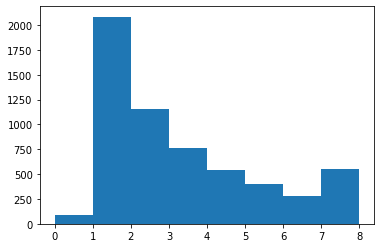

In [69]:
plt.hist(PosQuarters, bins=8)

Okay, that's better!  A large group of customers order every quarter.

## Identifying customers that churned in the last half of 2011 

We select 3 subsets of customers.  
* churn: customers who had at most 2 quarters of non purchases over the first 6 quarters and had no purchases in the last two quarters
* strong: customers who had at most 2 quarters of non purchases over the first 6 quarters and purchased something in each of the last two quarters
* regulars: customers who had at most 2 quarters of non purchases over the first 6 quarters. This group will include 'churn' and 'strong' customers as well as customers who purchased in one of the last two quarters.  


In [70]:
#PosQuarters = []
churn = []
strong = []
regulars = []


for series in RFM.Mt:
    if series[0:6].count(0.0) < 3:
        regulars.append(True)
    else:
        regulars.append(False)

    if series[0:6].count(0.0) < 3 and series[6:8].count(0.0) == 2:
        churn.append(True)
    else:
        churn.append(False)

    if series.count(0.0) < 3 and series[6:8].count(0.0) == 0:
        strong.append(True)
    else:
        strong.append(False)


In [71]:
print("We have identified", sum(regulars), "customers who were regulars for the first 6 quarters.")
print("Of them ",
      sum(churn), "customers churned in the last half of 2011 and", sum(strong), 
      "customers were strong in the last half of 2011")

We have identified 1181 customers who were regulars for the first 6 quarters.
Of them  171 customers churned in the last half of 2011 and 651 customers were strong in the last half of 2011


### What do we know about these customers?  Which regular customers are at risk of churning?

To find out more, we will create a list of dataframes for each timestep with recency, monetary, frequency as well as monetary difference (M(t)-M(t-1)) and frequency difference (F(t)-F(t-1)).  This we can use at each timestep to determine if a customer will churn.    

In [178]:
reg_custs = np.array(customers)[regulars]

RFMs=[]
num_quarters=0
step = 90
i = 720

#Set up RFMQ1 first, because it has no diff vals
RFM = []

df_quarterly = df_retailG.where((df_retailG.recency <= i) & (df_retailG.recency > i-step))
df_quarterly.dropna(inplace=True)
    
quarterly = df_quarterly.groupby("custID", as_index=False).sum()
count = df_quarterly.groupby("custID", as_index=False).count()
#    print("quarterly", quarterly)
#    print("count", count)
for customer in reg_custs:
    a = quarterly.where(quarterly.custID == customer)
    a.dropna(inplace=True)
    freq = count.where(quarterly.custID == customer)['index']
    freq.dropna(inplace=True)


    if a.empty: #No orders found in this quarter for this customer
        RFM.append([customer, 0.0, 0.0, 1])

    else: #Found some orders
        RFM.append([customer, float(a.monetary), float(freq), 0])
                    
RFM = pd.DataFrame(RFM, columns = ["custID", "Mt", "Ft", "Rt"])
RFM.set_index("custID", inplace=True)
RFMs.append(RFM)

#Now the rest


#For each quarter we create a new dataframe that contains recency, Monetary, frequency and 
#difference in montetry/frequency from previous quarter 
#These dataframes will then be used to predict churn
for i in range(720-step, 0, -step):
    print("quarter", i/step)
    RFM=[]
    num_quarters+=1
    #first grab the subset of the data in this range
    df_quarterly = df_retailG.where((df_retailG.recency <= i) & (df_retailG.recency > i-step))
    df_quarterly.dropna(inplace=True)
    
    quarterly = df_quarterly.groupby("custID", as_index=False).sum()
    count = df_quarterly.groupby("custID", as_index=False).count()
#    print("quarterly", quarterly)
#    print("count", count)
    for customer in reg_custs:
        a = quarterly.where(quarterly.custID == customer)
        freq = count.where(quarterly.custID == customer)['index']
        freq.dropna(inplace=True)
#        print("freq", freq)
        a.dropna(inplace=True)
        if a.empty: #No orders found in this quarter for this customer
            Mt=0.0
            Ft=0.0
            Rt=1
            diffMt = RFMs[-1].loc[customer]['Mt'] - Mt
            diffFt = RFMs[-1].loc[customer]['Ft'] - Ft
            RFM.append([customer, Mt, Ft, Rt, diffMt, diffFt])

        else: #Found some orders
            Mt=float(a.monetary)
            Ft=float(freq)
            Rt=0
            diffMt = RFMs[-1].loc[customer]['Mt'] - Mt
            diffFt = RFMs[-1].loc[customer]['Ft'] - Ft
            RFM.append([customer, Mt, Ft, Rt, diffMt, diffFt])
            
    RFM = pd.DataFrame(RFM, columns = ["custID", "Mt", "Ft", "Rt", "diffMt", "diffFt"])
    RFM.set_index("custID", inplace=True)        
    RFMs.append(RFM)    



quarter 7.0
quarter 6.0
quarter 5.0
quarter 4.0
quarter 3.0
quarter 2.0
quarter 1.0


### Create model variables
We want to predict churn, so y will be "True" for churn customers and "False" otherwise
X will be the RFM dataframe at quarter 6 (-3 quarters from the end)

In [179]:
churn_custs = np.array(customers)[churn]
y=[]
for cust in RFM.index:
    if cust in churn_custs:
        y.append(True)
    else:
        y.append(False)


X=RFMs[-3]

#### check to make sure we're comparing apples to apples

In [180]:
len(X), len(y), sum(y)

#len(churn)

(1181, 1181, 171)

#### Let's normalize these numbers

In [181]:
X['Mt'] = preprocessing.normalize([X['Mt']], norm='max')[0] 
X['Ft'] = preprocessing.normalize([X['Ft']], norm='max')[0] 
X['diffMt'] = preprocessing.normalize([X['diffMt']], norm='max')[0] 
X['diffFt'] = preprocessing.normalize([X['diffFt']], norm='max')[0] 

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [183]:
classifier = RandomForestClassifier(random_state=0)  
classifier.fit(X_train, y_train)  
predictions = classifier.predict(X_test)

In [184]:
sum(predictions), len(predictions), len(y_test)

(24, 237, 237)

In [185]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predictions, y_test)

array([[186,  27],
       [ 13,  11]])

In [186]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test,predictions ))  
print("Accuracy {:0.2f}%".format(100.0* accuracy_score(y_test, predictions)))

              precision    recall  f1-score   support

       False       0.87      0.93      0.90       199
        True       0.46      0.29      0.35        38

    accuracy                           0.83       237
   macro avg       0.67      0.61      0.63       237
weighted avg       0.81      0.83      0.82       237

Accuracy 83.12%


### Results
83% accuracy -- marginal, but potentially useful.  The confusion matrix:
[[186, 27],
[13, 11]]
shows us were we can improve -- We have relatively high false positives and false negatives.  We are correctly predicting 11 churn customers and 186 "strong" customers.  


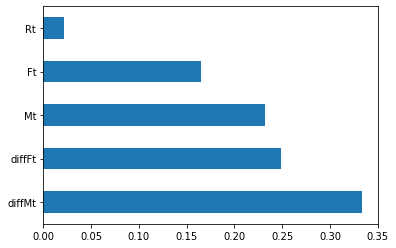

In [187]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### The difference in Ft and Mt are the most important variables for predicting churn, followed by Ft and Mt.  
  

####  Now we predict which customers are likely to churn in the at the end of 2011.  

In [188]:
regulars_end2011 = [x for x in reg_custs if x not in churn_custs]

df_regs_end2011 = df_retailG[df_retailG['custID'].isin(regulars_end2011)]

#df_strong = df_retailC.loc[np.where(df_retailC.custID.isin(strong_custs)].copy(deep=True)

In [189]:
X_end2011=X=RFMs[-1]

X_end2011['Mt'] = preprocessing.normalize([X_end2011['Mt']], norm='max')[0] 
X_end2011['Ft'] = preprocessing.normalize([X_end2011['Ft']], norm='max')[0] 
X_end2011['diffMt'] = preprocessing.normalize([X_end2011['diffMt']], norm='max')[0] 
X_end2011['diffFt'] = preprocessing.normalize([X_end2011['diffFt']], norm='max')[0] 

predictions = classifier.predict(X_end2011)

In [190]:
sum(predictions)

266

In [191]:
len(predictions), len(reg_custs)

(1181, 1181)

In [192]:
custs_to_watch = np.array(reg_custs)[predictions]

#### This includes some customers who are already in our churn list, so let's remove them.  

In [193]:
already_churned = [x for x in custs_to_watch if x in churn_custs]
new_concerns = [x for x in custs_to_watch if x not in churn_custs]
print("number of customers in danger of churning at the end of 2011:", len(new_concerns))

number of customers in danger of churning at the end of 2011: 95


In [194]:
print("Here is a list of the customers who are in danger of churning at the end of 2011:")
print(new_concerns)

Here is a list of the customers who are in danger of churning at the end of 2011:
[12399.0, 12409.0, 12494.0, 12609.0, 12649.0, 12708.0, 12778.0, 12909.0, 12910.0, 12924.0, 12987.0, 12993.0, 12997.0, 13037.0, 13131.0, 13141.0, 13330.0, 13455.0, 13476.0, 13539.0, 13557.0, 13573.0, 13623.0, 13662.0, 13719.0, 13728.0, 13771.0, 13787.0, 13883.0, 13980.0, 14032.0, 14064.0, 14075.0, 14078.0, 14113.0, 14152.0, 14205.0, 14210.0, 14233.0, 14264.0, 14389.0, 14514.0, 14538.0, 14541.0, 14560.0, 14584.0, 14631.0, 14758.0, 14913.0, 14952.0, 15002.0, 15179.0, 15227.0, 15394.0, 15421.0, 15563.0, 15641.0, 15660.0, 15694.0, 15774.0, 15785.0, 15796.0, 15903.0, 16008.0, 16045.0, 16099.0, 16104.0, 16177.0, 16209.0, 16233.0, 16235.0, 16400.0, 16584.0, 16668.0, 16833.0, 16859.0, 16938.0, 17002.0, 17027.0, 17050.0, 17071.0, 17083.0, 17147.0, 17190.0, 17227.0, 17320.0, 17400.0, 17540.0, 17618.0, 17739.0, 17888.0, 17913.0, 17929.0, 18178.0, 18236.0]


A quick look at using support vector machines and SGD classfiers gives a null result.  I would like to fine tune parameters and see what the issue is here.  I'll probably continue to work on this after submitting...  

In [195]:
clf = svm.SVC()
clf.fit(X_train, y_train)
sum(clf.predict(X_test))

0

In [196]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)

sum(clf.predict(X_test))

0

## Final thoughts
This was an interesting dataset to work through and I learned a few new things!  

If I had more time I would:
* Spend more time on part 3 -- modeling the data. 
  * Fine tune our model to get better accuracy
  * Look more closely at SGD and SVM models
  * try a couple other models (e.g. LSTM, clustering over time, etc).  
* clean up the code and create more functions to streamline things
* optimize the code involved in setting up the RFM dataframes

* explore better visualizations

If I were able to send myself advice before starting the project I would recommend:
* skip the word clouds -- they take forever to run and it's not clear how useful they were
* don't spend so much time worrying about cancelled orders -- there doesn't seem to be anything suspicious there.  